
In this experiment we will load a pretrained distilBert and fine-tune it on an augmented version of the OPP-115 train set, show that it performs better on an adversarial version of the validation set, and finally train it again on both the train set and validation set (combined set) before evaluating it on the test set as the final evaluation.

## Imports & Dependencies

In [ ]:
%%shell
rm -rf ./sample_data/
pip install transformers
pip install textattack
pip install torch==1.6 # need torch 1.6 for the augmenter to work

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
import numpy as np
from google.colab import drive
import transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, BertConfig, DistilBertPreTrainedModel
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle
import textattack
from tqdm import tqdm

## Load & Prepare the OPP-115 Dataset from the Benchmark Paper ("Majority" Version)

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/Polisis_Benchmark/datasets/Majority/train_dataset.csv', names=['segment', 'label'])
valid_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/Polisis_Benchmark/datasets/Majority/validation_dataset.csv', names=['segment', 'label'])
test_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/Polisis_Benchmark/datasets/Majority/test_dataset.csv', names=['segment', 'label'])
print('train set labels')
print('\n'.join([str(i)+'. '+ s for i, s in enumerate(train_set.label.unique())]))
print()
print('valid set labels')
print('\n'.join([str(i)+'. '+ s for i, s in enumerate(valid_set.label.unique())]))
print()
print('test set labels')
print('\n'.join([str(i)+'. '+ s for i, s in enumerate(test_set.label.unique())]))
print()

train set labels
0. First Party Collection/Use
1. Third Party Sharing/Collection
2. User Choice/Control
3. Privacy contact information
4. Introductory/Generic
5. Practice not covered
6. Data Security
7. User Access, Edit and Deletion
8. Policy Change
9. Do Not Track
10. International and Specific Audiences
11. Data Retention

valid set labels
0. International and Specific Audiences
1. Privacy contact information
2. First Party Collection/Use
3. Third Party Sharing/Collection
4. Introductory/Generic
5. Practice not covered
6. Data Security
7. User Access, Edit and Deletion
8. Do Not Track
9. Data Retention
10. Policy Change
11. User Choice/Control

test set labels
0. Introductory/Generic
1. Data Retention
2. User Access, Edit and Deletion
3. Privacy contact information
4. First Party Collection/Use
5. Third Party Sharing/Collection
6. Data Security
7. User Choice/Control
8. Policy Change
9. International and Specific Audiences
10. Practice not covered
11. Do Not Track



Convert text labels to numbers

In [ ]:
label2idx = dict([('First Party Collection/Use', 0),
             ('Third Party Sharing/Collection', 1),
             ('User Access, Edit and Deletion', 2),
             ('Data Retention', 3),
             ('Data Security', 4),
             ('International and Specific Audiences', 5),
             ('Do Not Track', 6),
             ('Policy Change', 7),
             ('User Choice/Control', 8),
             ('Introductory/Generic', 9),
             ('Practice not covered', 10),
             ('Privacy contact information', 11)])
idx2label = {value : key for (key, value) in label2idx.items()}

In [ ]:
train_set.label = train_set.label.apply(lambda s: label2idx[s])
valid_set.label = valid_set.label.apply(lambda s: label2idx[s])
test_set.label = test_set.label.apply(lambda s: label2idx[s])
print('train set labels')
print('\n'.join([str(i)+'. '+ str(s) for i, s in enumerate(train_set.label.unique())]))
print()
print('valid set labels')
print('\n'.join([str(i)+'. '+ str(s) for i, s in enumerate(valid_set.label.unique())]))
print()
print('test set labels')
print('\n'.join([str(i)+'. '+ str(s) for i, s in enumerate(test_set.label.unique())]))
print()

train set labels
0. 0
1. 1
2. 8
3. 11
4. 9
5. 10
6. 4
7. 2
8. 7
9. 6
10. 5
11. 3

valid set labels
0. 5
1. 11
2. 0
3. 1
4. 9
5. 10
6. 4
7. 2
8. 6
9. 3
10. 7
11. 8

test set labels
0. 9
1. 3
2. 2
3. 11
4. 0
5. 1
6. 4
7. 8
8. 7
9. 5
10. 10
11. 6



In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-cased')
train_encodings = tokenizer(train_set.segment.to_list(), truncation=True, padding=True)
val_encodings = tokenizer(valid_set.segment.to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_set.segment.to_list(), truncation=True, padding=True)
class OppDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = OppDataset(train_encodings, train_set.label.to_list())
val_dataset = OppDataset(val_encodings, valid_set.label.to_list())
test_dataset = OppDataset(test_encodings, test_set.label.to_list())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Training (Augmented training set)


In [ ]:
output_dir = '/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/robust_model_20_epochs_opp'

Augmnet the train set with adversarial examples --

In [ ]:
adv_train_subset = train_set.iloc[:int(len(train_set)/2)].copy()
augmenter = textattack.augmentation.recipes.WordNetAugmenter(
    pct_words_to_swap=0.1, 
    transformations_per_example=1
    )
adv_train_subset.segment = adv_train_subset.segment.apply(lambda s: augmenter.augment(s)[0])
print(adv_train_subset.equals(train_set.iloc[:int(len(train_set)/2)]))

False


In [ ]:
augmented_train_set = train_set.copy().append(adv_train_subset)
augmented_train_set.to_csv(output_dir+'/augmented_train_set.csv')

augmented_train_encodings = tokenizer(augmented_train_set.segment.to_list(), truncation=True, padding=True)
augmented_train_dataset = OppDataset(augmented_train_encodings, augmented_train_set.label.to_list())

In [ ]:
smaller_augmented_train_set = augmented_train_set.iloc[:int(len(train_set)*1.20)]
augmented_train_encodings = tokenizer(smaller_augmented_train_set.segment.to_list(), truncation=True, padding=True)
augmented_train_dataset = OppDataset(augmented_train_encodings, smaller_augmented_train_set.label.to_list())

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir, # output directory for model predictions and checkpoints
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    logging_dir=output_dir+'/logs',
    load_best_model_at_end=True, # will save/checkpoint the model after every evaluation
    evaluation_strategy="epoch", # will evaluate every epoch
    # DO NOT USE # label_names=label_names,  # DO NOT USE THIS --- THROWS ERROR
)

NUM_LABELS = len(idx2label)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-cased", 
    num_labels=NUM_LABELS,
    id2label=idx2label, # use to show text labels
    )

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=augmented_train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)

# Start the training
trainer.train()
# Save model
model.save_pretrained(output_dir)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.b

Epoch,Training Loss,Validation Loss
1,1.582400,1.593798
2,1.250400,1.014523
3,0.852900,0.949055
4,0.731100,0.947929
5,0.621100,0.846157
6,0.699600,0.845683
7,0.519800,0.922354
8,0.462400,0.877539
9,0.384700,0.953834
10,0.311200,0.884321


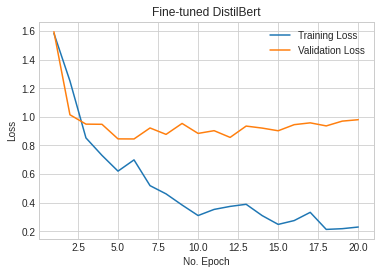

In [ ]:
log = """Epoch	Training Loss	Validation Loss
1	1.582400	1.593798
2	1.250400	1.014523
3	0.852900	0.949055
4	0.731100	0.947929
5	0.621100	0.846157
6	0.699600	0.845683
7	0.519800	0.922354
8	0.462400	0.877539
9	0.384700	0.953834
10	0.311200	0.884321
11	0.354000	0.903355
12	0.375000	0.856497
13	0.389700	0.935518
14	0.310800	0.921465
15	0.249400	0.902773
16	0.276200	0.945398
17	0.333600	0.958058
18	0.214400	0.936690
19	0.219500	0.970102
20	0.231100	0.979979
"""
with open(output_dir+'/train_history_log', 'w') as f:
    f.write(log)

history = pd.read_csv(output_dir+'/train_history_log',sep='\t')

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['Training Loss'], label='Training Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel("No. Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuned DistilBert")
plt.legend()
plt.savefig(output_dir+'/train_history_plot.png', dpi=300)
plt.show()

## Evaluation (Adversarial validation set from previous experiment)


In [ ]:
adv_valid_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/non-robust_model_300_epochs_opp/adv_valid_set.csv')
adv_valid_encodings = tokenizer(adv_valid_set.segment.to_list(), truncation=True, padding=True)
adv_valid_dataset = OppDataset(adv_valid_encodings, adv_valid_set.label.to_list())

model = DistilBertForSequenceClassification.from_pretrained(
    output_dir, 
    num_labels=len(idx2label),
    id2label=idx2label, # use to show text labels
)
model.eval()
evaluator = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=adv_valid_dataset,             # evaluation dataset
)

eval_results = evaluator.evaluate()
print()
for key in ['eval_loss']:
    value = eval_results[key]
    if type(value) != type(np.array([])):
        print(f'{key}:', value)
    else:
        print(f'{key}:\n')
        for lab, val in zip(label_names, value): 
            print(f'{lab}:', val)
    print()

eval_results = evaluator.predict(adv_valid_dataset)
model.to('cpu')

# produce one-hot preds 
y_true = eval_results[1].tolist()
y_pred = eval_results[0].argmax(axis=-1).tolist()

label_names = list(label2idx.keys())
# Print and save classification report
print('Validation Flat Accuracy: ', accuracy_score(y_true, y_pred),'\n')

clf_report = classification_report(y_true, y_pred, target_names=label_names)
pickle.dump(clf_report, open(output_dir+'/classification_report.txt','wb')) #save report
print(clf_report)


eval_loss: 0.9166969060897827

Validation Flat Accuracy:  0.7067901234567902 

                                      precision    recall  f1-score   support

          First Party Collection/Use       0.72      0.77      0.74       176
      Third Party Sharing/Collection       0.76      0.68      0.72       158
      User Access, Edit and Deletion       0.61      0.92      0.73        24
                      Data Retention       0.36      0.36      0.36        14
                       Data Security       0.65      0.71      0.68        31
International and Specific Audiences       0.77      0.90      0.83        41
                        Do Not Track       0.75      0.50      0.60         6
                       Policy Change       0.79      0.76      0.78        25
                 User Choice/Control       0.63      0.67      0.65        48
                Introductory/Generic       0.76      0.72      0.74        72
                Practice not covered       0.32      0.33    

## Train one last time (augmented training set + validation set)

In [ ]:
augmented_train_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/robust_model_10_epochs_opp/augmented_train_set.csv')
smaller_augmented_train_set = augmented_train_set.iloc[:int(len(train_set)*1.20)]

In [ ]:
output_dir = '/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/final_robust_model_20_epochs_opp'

In [ ]:
final_train_set = smaller_augmented_train_set.append(valid_set)

final_train_encodings = tokenizer(final_train_set.segment.to_list(), truncation=True, padding=True)
final_train_dataset = OppDataset(final_train_encodings, final_train_set.label.to_list())

training_args = TrainingArguments(
    output_dir=output_dir, # output directory for model predictions and checkpoints
    num_train_epochs=20,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    logging_dir=output_dir+'/logs',
    load_best_model_at_end=True, # will save/checkpoint the model after every evaluation
    evaluation_strategy="epoch", # will evaluate every epoch
    # DO NOT USE # label_names=label_names,  # DO NOT USE THIS --- THROWS ERROR
)

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(idx2label),
    id2label=idx2label, # use to show text labels
    )

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    eval_dataset=test_dataset,
    train_dataset=final_train_dataset,         # training dataset
)

# Start the training
trainer.train()
# Save model
model.save_pretrained(output_dir)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bia

Epoch,Training Loss,Validation Loss
1,1.437500,1.175597
2,0.856900,0.952895
3,0.798100,0.888744
4,0.620500,0.984051
5,0.514800,0.868919
6,0.604000,0.815988
7,0.498600,0.793339
8,0.403200,0.815822
9,0.422400,0.854183
10,0.439000,0.864156


## Final Evaluation (on test set)

Let's do a final evaluation of our robustified, fine-tuned model on the test set.

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    output_dir, 
    num_labels=len(idx2label),
    id2label=idx2label, # use to show text labels
)
model.eval()
evaluator = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=test_dataset,             # evaluation dataset
)

eval_results = evaluator.predict(test_dataset)
model.to('cpu')

# produce one-hot preds 
y_true = eval_results[1].tolist()
y_pred = eval_results[0].argmax(axis=-1).tolist()

label_names = list(label2idx.keys())
# Print and save classification report
print('Test Set Flat Accuracy: ', accuracy_score(y_true, y_pred),'\n')

clf_report = classification_report(y_true, y_pred, target_names=label_names)
pickle.dump(clf_report, open(output_dir+'/classification_report.txt','wb')) #save report
print(clf_report)

Test Set Flat Accuracy:  0.7466986794717887 

                                      precision    recall  f1-score   support

          First Party Collection/Use       0.76      0.85      0.80       250
      Third Party Sharing/Collection       0.77      0.70      0.74       203
      User Access, Edit and Deletion       0.52      0.62      0.57        24
                      Data Retention       0.38      0.36      0.37        14
                       Data Security       0.87      0.65      0.74        40
International and Specific Audiences       0.73      0.86      0.79        56
                        Do Not Track       0.67      0.67      0.67         3
                       Policy Change       0.77      0.95      0.85        21
                 User Choice/Control       0.83      0.71      0.77        77
                Introductory/Generic       0.67      0.83      0.74        78
                Practice not covered       0.50      0.12      0.19        25
         Privacy 

Generate final conf. matrix --

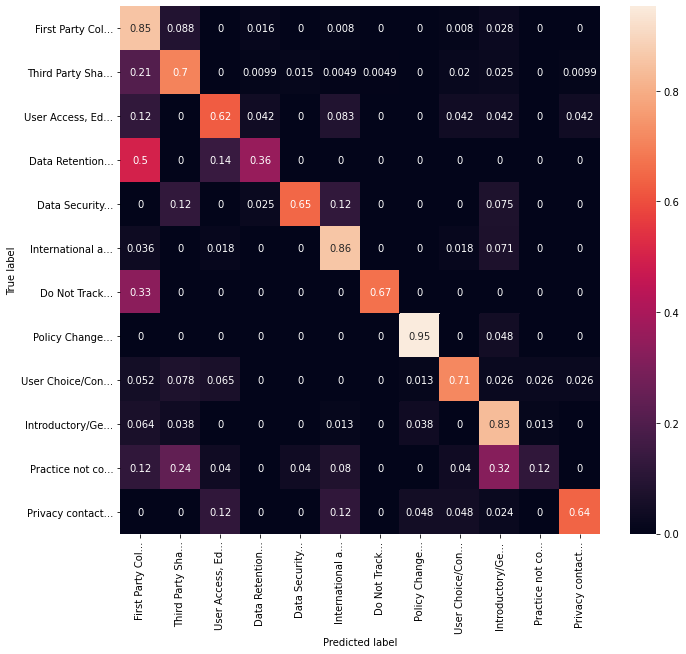

In [ ]:
# model = DistilBertForSequenceClassification.from_pretrained(
#     output_dir, 
#     num_labels=len(idx2label),
#     id2label=idx2label, # use to show text labels
# )

# model.eval()
# evaluator = Trainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     eval_dataset=test_dataset,             # evaluation dataset
# )

# eval_results = evaluator.predict(test_dataset)
# model.to('cpu')

# # produce one-hot preds 
# y_true = eval_results[1].tolist()
# y_pred = eval_results[0].argmax(axis=-1).tolist()

label_names = list(label2idx.keys())
label_names = [s[:15]+'...' for s in label_names]

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Plot normalized confusion matrix
con_mat = confusion_matrix(y_true, y_pred, normalize='true')
import pandas as pd
con_mat_df = pd.DataFrame(con_mat, 
                          index = label_names,
                          columns = label_names)
figure = plt.figure(figsize=(10, 9))
import seaborn as sns
sns.heatmap(con_mat_df, annot=True)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(output_dir+'/final_conf_matrix.png', dpi=300)
plt.show()